In [1]:
import matplotlib.pyplot as plt

%matplotlib widget

/Users/rohan/Documents/bwsi/bwsi-env/lib/python3.9/site-packages/noggin/plotter.py:364: UserWarning: Live plotting is not supported when matplotlib uses the 'module://ipympl.backend_nbagg'
backend. Instead, use the 'nbAgg' backend.

In a Jupyter notebook, this can be activated using the cell magic:
   %matplotlib notebook.
  warn(cleandoc(_inline_msg.format(self._backend)))


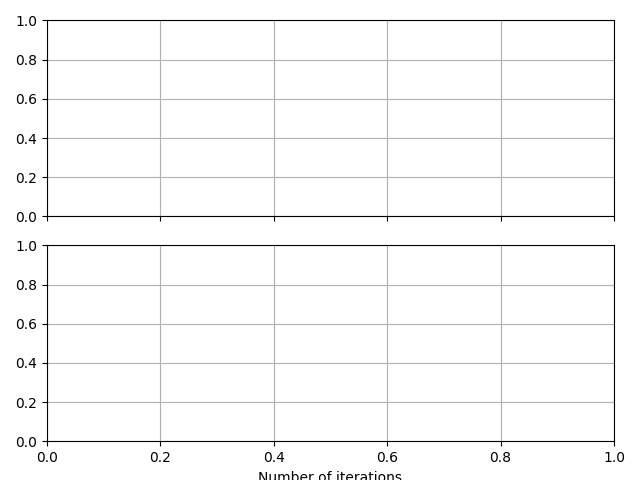

In [2]:
from noggin import create_plot

# this will create a noggin plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [3]:
from model import ImageModel
from model import compute_loss_and_accuracy
import embeddings as em
import numpy as np
from mynn.optimizers.sgd import SGD
from cogworks_data.language import get_data_path
from pathlib import Path
import json
from batches import create_batches
from sklearn.utils import shuffle
from tqdm import tqdm
from datetime import datetime

# run this model to train our single-layer neural network
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    cocodata = json.load(f)

# load saved image descriptor vectors
import pickle
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)


resnet18_ids = set(resnet18_features.keys())
cocodata['images'] = [
  img for img in cocodata["images"] if img["id"] in resnet18_ids
]
cocodata['annotations'] = [
  anot for anot in cocodata["annotations"] if anot['image_id'] in resnet18_ids
]

#load glove
glove = em.Glove()
idf = em.IDF()

image_ids, caption_ids, confusor_ids = create_batches(cocodata)
image_ids, captions_ids, confusor_ids = shuffle(
  image_ids, caption_ids, confusor_ids, random_state=0
)

data_len = image_ids.shape[0]
test_idx = data_len // 5

test_image_ids = image_ids[:test_idx]
test_captions_ids = captions_ids[:test_idx]
test_confusor_ids = confusor_ids[:test_idx]
train_image_ids = image_ids[test_idx:]
train_captions_ids = captions_ids[test_idx:]
train_confusor_ids = confusor_ids[test_idx:]

train_len = train_image_ids.shape[0]
test_len = test_image_ids.shape[0]

EPOCHS = 20
BATCH_SIZE = 256

model = ImageModel(512, 200)
optim = SGD(model.parameters, learning_rate = 1e-3, momentum=0.9)

for epoch_cnt in range(EPOCHS):
    idxs = np.arange(train_len)
    np.random.shuffle(idxs)
    
    for batch_cnt in tqdm(range(0, train_len//BATCH_SIZE)):
        batch_indices = idxs[batch_cnt*BATCH_SIZE : (batch_cnt + 1)*BATCH_SIZE]
        
        batch_img_ids = train_image_ids[batch_indices]
        batch_conf_ids = train_confusor_ids[batch_indices]
        batch_caption_ids = train_captions_ids[batch_indices]

        batch_imgs = np.empty((batch_img_ids.shape[0], 512))
        batch_confs = np.empty((batch_conf_ids.shape[0], 512))

        for i in range(BATCH_SIZE):
          batch_imgs[i] = resnet18_features[batch_img_ids[i]][0, :]
          batch_confs[i] = resnet18_features[batch_conf_ids[i]][0, :]

        batch_caps = np.empty((BATCH_SIZE, 200))

        for i in range(BATCH_SIZE):
          batch_caps[i] = em.embed(
            cocodata['annotations'][batch_caption_ids[i]]['caption'], idf, glove
          )

        embedding_true, embedding_conf = model(batch_imgs, batch_confs)

        # compute loss and accuracy using margin loss ranking
        loss, accuracy = compute_loss_and_accuracy(batch_caps, embedding_true, embedding_conf) 

        loss.backward()

        optim.step()

        # print('epoch:', epoch_cnt, '\tbatch:', batch_cnt, '\tloss:', loss, '\tacc:', accuracy)

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : accuracy},
                                 batch_size=BATCH_SIZE)

    if epoch_cnt % 5 == 0 and epoch_cnt > 0:
        now = datetime.now()
        fpath = 'model-%d-%d-%s.npz' % (EPOCHS, epoch_cnt, now.strftime('%Y-%m-%d-%H%M%S'))
        model.save_model(fpath)

plotter.plot()

/Users/rohan/Documents/bwsi/bwsi-env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 1291/1291 [00:49<00:00, 26.19it/s]


In [4]:
# EVALUTATION
def evaluate_model(model):
    test_imgs = np.empty((test_image_ids.shape[0], 512))
    test_confs = np.empty((test_confusor_ids.shape[0], 512))

    for i in range(test_imgs.shape[0]):
        test_imgs[i] = resnet18_features[test_image_ids[i]][0, :]
        test_confs[i] = resnet18_features[test_confusor_ids[i]][0, :]

    test_caps = np.empty((test_captions_ids.shape[0], 200))

    for i in range(test_caps.shape[0]):
        test_caps[i] = em.embed(
            cocodata['annotations'][test_captions_ids[i]]['caption'], idf, glove
        )

    embedding_true_image = model.predict(test_imgs)
    embedding_confusor_image = model.predict(test_confs)

    similarity_true_image = np.einsum(
        "nd,nd->n", test_caps, embedding_true_image)
    similarity_confusor_image = np.einsum(
        "nd,nd->n", test_caps, embedding_confusor_image)

    correct_predictions = similarity_true_image > similarity_confusor_image

    return np.mean(correct_predictions)

In [5]:
evaluate_model(model)

0.9047682423685134

In [23]:
def save_model(model, path):
    """Path to .npz file where model parameters will be saved."""
    with open(path, "wb") as f:
        np.savez(f, *(x.data for x in model.parameters))

def load_model(model, path):
    with open(path, "rb") as f:
        for param, (name, array) in zip(model.parameters, np.load(f).items()):
            param.data[:] = array
    return param

In [24]:
from datetime import datetime

now = datetime.now()
fpath = 'model-%d-%s.npz' % (EPOCHS, now.strftime('%Y-%m-%d-%H%M%S'))
save_model(model, fpath)

In [25]:
loaded_model = ImageModel(512, 200)

params = load_model(loaded_model, 'model-5-2023-07-28-165517.npz')

In [26]:
# EVALUTATION
evaluate_model(loaded_model)

0.9449008481446081